In [1]:
import os, sys
import dotenv
dotenv.load_dotenv('../.env')

import numpy as np
import torch
import pandas as pd
from scipy.stats import kendalltau, pearsonr, spearmanr
import pandas as pd
from torchvision import transforms

import wandb
from collections import defaultdict
import json
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy
import warnings

sys.path.append('../')
from common import OnnxModel
from metrics.metrics import calculate_open_loop_metrics, calculate_closed_loop_metrics
from dataloading.nvidia import NvidiaElvaDataset, NvidiaDataset

WANDB_ENTITY = os.getenv('WANDB_ENTITY')
WANDB_PROJECT = os.getenv('WANDB_PROJECT')

In [2]:
def wandb_model_path_parse(model_path):
    return model_path.replace('_models/', '').replace('.onnx', '')

def add_wandb_metrics(df):
    '''Adds eval metrics to the table, such as best MAE and Vista performance.
    '''
    api = wandb.Api()
    runs = api.runs(f'{WANDB_ENTITY}/{WANDB_PROJECT}')

    # 1 evaluation (for which we show metrics) = A sum of single runs on each of the tracks below. 
    # If the Vista run was done only on a subset, we check if 
    # multiple Vista runs cover the full set of tracks, and if so, we count 
    # it as 1 evaluation (or more, if runs cover the full set multiple times)
    vista_counted_tracks = ["2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk", "2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk"]
    model_vista_performance = defaultdict(lambda: defaultdict(list))

    for run in runs:

        # training run
        any_drives_with_this_model = df.loc[df['training_run'] == run.id].size > 0
        if any_drives_with_this_model:
            best_mae = 2**32
            for i, row in run.history(keys=['mae']).iterrows():
                if row['mae'] < best_mae: best_mae = row['mae']

            df.loc[df['training_run'] == run.id, 'val_mae'] = best_mae
            df.loc[df['training_run'] == run.id, 'model_type'] = run.config['model_type']

        # vista run
        if run.state == 'finished' and run.summary.get('crash_count', None) is not None:
            model_name = wandb_model_path_parse(run.config['model_path'])
            crash_count = run.summary.get('crash_count', None)
            traces = run.config['trace_paths']
            traces_str_list = [trace[0] if hasattr(trace, '__iter__') else trace for trace in traces]
            if set(traces_str_list) == set(vista_counted_tracks):
                model_vista_performance[model_name]['complete'].append(crash_count)
            else:
                for trace in traces_str_list:
                    if trace in vista_counted_tracks:
                        model_vista_performance[model_name][trace].append(crash_count)

        # evaluation run
        if run.state == 'finished' and 'offline-elva-evaluation' in run.tags:
            model_name = wandb_model_path_parse(run.config['model_path'])
            df.loc[df['model_name'] == model_name, 'elva_mae'] = run.summary['mae']
            df.loc[df['model_name'] == model_name, 'elva_whiteness'] = run.summary['whiteness']
            df.loc[df['model_name'] == model_name, 'elva_expert_whiteness'] = run.summary['expert_whiteness']

    for model_name, perf_by_trace in model_vista_performance.items():
        num_complete_evaluations = len(perf_by_trace['complete']) # runs with all tracks included

        # add the # of times all tracks are covered by partial evaluations (count each full coverage as one evaluation)
        num_evaluations_per_track = { trace: len(crashes) for trace, crashes in perf_by_trace.items() if trace != 'complete' }
        model_tested_in_all_tracks = set(vista_counted_tracks).issubset(set(perf_by_trace.keys()))

        num_complete_evaluations_from_partial = min(num_evaluations_per_track.values()) if model_tested_in_all_tracks else 0 
        total_crashes_from_partial = 0

        # if some run(s) don't add up to a complete evaluation, will drop them
        for i in range(num_complete_evaluations_from_partial):
            for trace, crashes in perf_by_trace.items():
                if trace == 'complete': continue
                total_crashes_from_partial += crashes[i]
        
        total_evaluations = num_complete_evaluations + num_complete_evaluations_from_partial
        total_crashes = sum(perf_by_trace['complete']) + total_crashes_from_partial

        if total_evaluations > 0:
            avg_crashes_per_eval = total_crashes / total_evaluations
        else:
            avg_crashes_per_eval = None
        df.loc[df['model_name'] == model_name, 'vista_interventions'] = avg_crashes_per_eval

    df['vista_interventions'] = df['vista_interventions'].convert_dtypes()
    df['real_interventions'] = df['real_interventions'].convert_dtypes()
    with open('model_perf.json', 'w') as f:
        json.dump(model_vista_performance, f, indent=2)

    return df

In [3]:
# ONLINE METRICS

track_direction_change_location = np.array([-9683.68050786, -1542.68155186])
root_path = Path("/data/Bolt/end-to-end/drives-ebm-paper/")
expert_ds = NvidiaDataset([root_path / '2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk'])
expert_back_ds = NvidiaDataset([root_path / '2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk'])

def are_locations_close(loc_a, loc_b, threshold=50):
    return np.linalg.norm(loc_a - loc_b) < threshold

def get_closest_frame_by_loc(df, target_loc):
    locations = df[['position_x', 'position_y']].to_numpy().astype(np.float32)
    df['distance_to_target'] = np.linalg.norm(locations - target_loc)
    return df.loc[df['distance_to_target'].idxmin()]

def get_closest_row_idx_by_timestamp(df, dt):
    df['timestamp'] = pd.to_datetime(df['index'])
    return (abs(df['timestamp'] - dt)).idxmin()

def get_longest_intervention_periods(df):
    df['autonomous_next'] = df['autonomous'].shift(-1)
    starts_ends_df = df[(df['autonomous'] & (df['autonomous_next'] == False)) | ((df['autonomous'] == False) & df['autonomous_next'])]
    starts_ends = [row['row_id'] for i, row in starts_ends_df.iterrows()]
    starts = np.array(starts_ends)[::2]
    ends = np.array(starts_ends)[1::2]
    longest_idxs = np.argsort(ends - starts)
    return (starts[longest_idxs], ends[longest_idxs])

def split_back_forth_drive_into_two(dataset):

    frames_df = dataset.frames
    vehicle_cmd_df = dataset.vehicle_cmd_frames
    # find the longest intervention period
    found_direction_change = False
    for forward_end, forward_start in zip(*get_longest_intervention_periods(frames_df)):
        if are_locations_close(frames_df[frames_df['row_id'] == forward_end][['position_x', 'position_y']].to_numpy(), track_direction_change_location) or \
            are_locations_close(frames_df[frames_df['row_id'] == forward_start][['position_x', 'position_y']].to_numpy(), track_direction_change_location):
            found_direction_change = True
            break

    if not found_direction_change:
        print('Couldn\'t find the longest intervention in the track direction change location')
        return None

    # split the drive into two
    df1 = frames_df[frames_df['row_id'] <= forward_end]
    df2 = frames_df[frames_df['row_id'] > forward_start]

    forward_end_ts = pd.to_datetime(df1.iloc[-1]['index'])
    backward_start_ts = pd.to_datetime(df2.iloc[0]['index'])

    forward_end_idx = get_closest_row_idx_by_timestamp(vehicle_cmd_df, forward_end_ts)
    backward_end_idx = get_closest_row_idx_by_timestamp(vehicle_cmd_df, backward_start_ts)

    df1_vehicle_cmd = vehicle_cmd_df.iloc[:forward_end_idx]
    df2_vehicle_cmd = vehicle_cmd_df.iloc[backward_end_idx:]

    # save the pandas dataframes back into NvidiaDataset objects
    dataset_forward = deepcopy(dataset)
    dataset_backward = deepcopy(dataset)
    dataset_forward.frames = df1
    dataset_forward.vehicle_cmd_frames = df1_vehicle_cmd
    dataset_backward.frames = df2
    dataset_backward.vehicle_cmd_frames = df2_vehicle_cmd

    return dataset_forward, dataset_backward

def add_online_metrics(df):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, row in tqdm(df.iterrows()):
            drives = row['drive']
            ds_forward = None
            ds_backward = None
            forward_metrics = {}
            backward_metrics = {}
            if len(drives) == 1:
                ds_combined = NvidiaDataset([root_path / drives[0]])
                if drives[0] not in ['2022-09-09-11-47-04', '2022-09-09-10-51-33-mdn-1-s1']: # unfinished single direction drive
                    ds_forward, ds_backward = split_back_forth_drive_into_two(ds_combined)
                else:
                    ds_forward = ds_combined
            elif len(drives) == 2:
                ds_forward = NvidiaDataset([root_path / drives[0]])
                ds_backward = NvidiaDataset([root_path / drives[1]])
            elif len(drives) == 3:
                assert '2022-08-31-15-18-55_elva_classifier_512_forward_continued' in drives[1]
                ds_forward = NvidiaDataset([root_path / drives[0], root_path / drives[1]])
                ds_backward = NvidiaDataset([root_path / drives[2]])

            if ds_forward:
                forward_metrics = calculate_closed_loop_metrics(ds_forward.frames, expert_ds.frames, ds_forward.vehicle_cmd_frames)
            if ds_backward:
                backward_metrics = calculate_closed_loop_metrics(ds_backward.frames, expert_back_ds.frames, ds_backward.vehicle_cmd_frames)

            try:
                del forward_metrics['interventions']
                del backward_metrics['interventions']
            except:
                pass

            metrics = {**forward_metrics}
            for k, v in backward_metrics.items():
                metrics[k] = metrics[k] + v
                if k not in ['distance']:
                    metrics[k] = metrics[k] / 2

            metrics['distance_per_intervention'] = metrics['distance'] / row['real_interventions']
            df.loc[i, metrics.keys()] = metrics.values()
            
    return df

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk: length=13858, filtered=2
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk: length=14249, filtered=1


In [107]:
datasets_forward

{'2022-09-09-10-04-05-mdn-3-s2 (forward)': <dataloading.nvidia.NvidiaDataset at 0x7f7b9d962340>,
 '2022-09-09-11-23-11-mdn-3-s3 (forward)': <dataloading.nvidia.NvidiaDataset at 0x7f7ba2189820>,
 '2022-09-09-11-00-03-mdn-5-s1 (forward)': <dataloading.nvidia.NvidiaDataset at 0x7f7b9fa8bb80>,
 '2022-09-09-10-27-50-mdn-5-s2 (forward)': <dataloading.nvidia.NvidiaDataset at 0x7f7b9efb7ee0>,
 '2022-08-31-15-37-37_elva_ebm_512_front': <dataloading.nvidia.NvidiaDataset at 0x7f7ba2189df0>,
 '2022-08-31-16-29-08_elva_ebm_256_front': <dataloading.nvidia.NvidiaDataset at 0x7f7b9d7d9a00>,
 '2022-08-31-17-16-19_elva_ebm_128_front': <dataloading.nvidia.NvidiaDataset at 0x7f7ba02dc670>,
 '2022-08-31-14-52-25_elva_classifier_512_forward + continued': <dataloading.nvidia.NvidiaDataset at 0x7f7ba0692f70>,
 '2022-08-31-16-00-20_elva_classifier_256_front': <dataloading.nvidia.NvidiaDataset at 0x7f7b9ff83130>,
 '2022-08-31-16-53-38_elva_classifier_128_front': <dataloading.nvidia.NvidiaDataset at 0x7f7b9ffa1e

In [194]:
# columns = ['model_name', 'model_class', 'total_MAE', 'same_track_MAE', 'vista_interventions', 'real_interventions']
columns = ['training_run', 'model_name', 'real_interventions', 'drive']

# build a dataframe with the results
rows = [
    ['1eq2jiva', 'mdn-1-s1', None, ('2022-09-09-11-47-04',)],
    ['1eq2jiva', 'mdn-1-s1', None, ('2022-09-09-10-51-33-mdn-1-s1',)],

    # ['1bdlpf8d', 'mdn-3-s2', 9,   ('2022-09-09-10-04-05-mdn-3-s2',)], # these MDNs are all in very sunny weather, let's only keep ones from cloudy final experiments
    # ['33smkc56', 'mdn-3-s3', 13,  ('2022-09-09-11-23-11-mdn-3-s3',)],
    # ['1hbbr6dm', 'mdn-5-s1', 15,  ('2022-09-09-11-00-03-mdn-5-s1',)],
    # ['27dfw40i', 'mdn-5-s2', 13,  ('2022-09-09-10-27-50-mdn-5-s2',)],

    ['3ftnqxcb', 'ebm-512-s1', 2,      ('2022-08-31-15-37-37_elva_ebm_512_front', '2022-08-31-15-48-15_elva_ebm_512_back',)],
    ['pg0eweml', 'ebm-256', 4,         ('2022-08-31-16-29-08_elva_ebm_256_front', '2022-08-31-16-42-01_elva_ebm_256_back',)],
    ['iddqahiv', 'ebm-128', 3,         ('2022-08-31-17-16-19_elva_ebm_128_front', '2022-08-31-17-26-53_elva_ebm_128_back',)],
    ['3g3wwx73', 'classifier-512', 1,  ('2022-08-31-14-52-25_elva_classifier_512_forward', '2022-08-31-15-18-55_elva_classifier_512_forward_continued', '2022-08-31-15-26-05_elva_classifier_512_back',)],
    ['1t7d1afv', 'classifier-256', 11, ('2022-08-31-16-00-20_elva_classifier_256_front', '2022-08-31-16-11-28_elva_classifier_256_back',)],
    ['2faagb62', 'classifier-128', 12, ('2022-08-31-16-53-38_elva_classifier_128_front', '2022-08-31-17-04-28_elva_classifier_128_back',)],

    ['3ftnqxcb', 'ebm-512-s1', 5, ('2022-09-02-11-04-39_elva_ebm_512_s1_rep1',)],
    ['3ftnqxcb', 'ebm-512-s1', 3, ('2022-09-02-11-27-02_elva_ebm_512_s1_rep2',)],
    ['3ftnqxcb', 'ebm-512-s1', 5, ('2022-09-02-11-48-55_elva_ebm_512_s1_rep3',)],
    ['3ftnqxcb', 'ebm-512-s1', 5, ('2022-09-08-10-13-30_ebm-512-s1',)],
    ['3dke382l', 'ebm-512-s2', 8, ('2022-09-08-10-38-33_ebm_512_s2',)],
    ['kozacohh', 'ebm-512-s3', 8, ('2022-09-08-11-01-21_ebm-512-s3',)],

    # ['13nkhdy1', 'mae-s1', 19, ('2022-09-02-09-54-31_elva_mae_s1_rep1',)], # unusually sunny weather/darkest shadows
    ['13nkhdy1', 'mae-s1', 12, ('2022-09-02-10-20-29_elva_mae_s1_rep2',)], # kinda sunny
    ['13nkhdy1', 'mae-s1', 10, ('2022-09-02-10-42-07_elva_mae_s1_rep3',)], # kinda sunny
    ['13nkhdy1', 'mae-s1', 4, ('2022-09-08-11-26-29_mae-s1',)],  # kinda cloudy? diff day than prev three
    ['bxd5wtqk', 'mae-s2', 1, ('2022-09-08-11-49-08_mae-s2',)],  # real cloudy
    ['gwgmsh0e', 'mae-s3', 6, ('2022-09-08-12-13-25_mae-s3',)],

    ['3ftnqxcb', 'ebm-512-s1', 2, ('e2e-ebm-512-s1-forward_2022-09-13-10-33-34', 'e2e-ebm-512-s1-backward_2022-09-13-10-44-25',)],
    ['2yofzwf0', 'ebm-50percent-s2', 23, ('e2e-ebm-50percent-s2-forward_2022-09-13-11-19-28', 'e2e-ebm-50percent-s2-backward_2022-09-13-11-30-33',)],
    ['zie8x2vl', 'ebm-20percent-s2', 23, ('e2e-ebm-20percent-s2-forward_2022-09-13-12-10-23', 'e2e-ebm-20percent-s2-backward_2022-09-13-12-21-25',)],

    ['3g3wwx73', 'classifier-512', 4, ('e2e-classifier-512-forward_2022-09-13-10-56-50', 'e2e-classifier-512-backward_2022-09-13-11-07-29',)],
    ['1t56cx3v', 'classifier-50percent-s1', 16, ('e2e-classifier-50percent-s1-forward_2022-09-13-11-42-53', 'e2e-classifier-50percent-s1-backward_2022-09-13-11-53-59',)],
    ['2ldsn0i0', 'classifier-20percent-s2', 31, ('e2e-classifier-20percent-s2-forward_2022-09-13-12-33-22', 'e2e-classifier-20percent-s2-backward_2022-09-13-12-44-44',)],
]

df = pd.DataFrame(rows, columns=columns)
df

,training_run,model_name,real_interventions,drive
0,1eq2jiva,mdn-1-s1,NaN,"(2022-09-09-11-47-04,)"
1,1eq2jiva,mdn-1-s1,NaN,"(2022-09-09-10-51-33-mdn-1-s1,)"
2,1bdlpf8d,mdn-3-s2,9.000000,"(2022-09-09-10-04-05-mdn-3-s2,)"
3,33smkc56,mdn-3-s3,13.000000,"(2022-09-09-11-23-11-mdn-3-s3,)"
4,1hbbr6dm,mdn-5-s1,15.000000,"(2022-09-09-11-00-03-mdn-5-s1,)"
5,27dfw40i,mdn-5-s2,13.000000,"(2022-09-09-10-27-50-mdn-5-s2,)"
6,3ftnqxcb,ebm-512-s1,2.000000,"(2022-08-31-15-37-37_elva_ebm_512_front, 2022-..."
7,pg0eweml,ebm-256,4.000000,"(2022-08-31-16-29-08_elva_ebm_256_front, 2022-..."
8,iddqahiv,ebm-128,3.000000,"(2022-08-31-17-16-19_elva_ebm_128_front, 2022-..."
9,3g3wwx73,classifier-512,1.000000,(2022-08-31-14-52-25_elva_classifier_512_forwa...


In [ ]:
df.to_csv('ebm-experiments.csv', index=False)

In [9]:
df = add_wandb_metrics(df)
df = add_online_metrics(df)
df.to_csv('ebm-experiments-results.csv', index=False)
df

0it [00:00, ?it/s]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-11-47-04: length=3364, filtered=0


1it [00:01,  1.31s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-10-51-33-mdn-1-s1: length=4700, filtered=0


2it [00:03,  2.01s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-10-04-05-mdn-3-s2: length=38861, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
3it [00:29, 12.65s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-11-23-11-mdn-3-s3: length=38857, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
4it [00:52, 16.78s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-11-00-03-mdn-5-s1: length=38100, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
5it [01:16, 19.31s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-10-27-50-mdn-5-s2: length=38317, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
6it [01:40, 21.06s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-37-37_elva_ebm_512_front: length=17873, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-48-15_elva_ebm_512_back: length=18822, filtered=0


7it [02:05, 22.21s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-29-08_elva_ebm_256_front: length=17991, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-42-01_elva_ebm_256_back: length=18865, filtered=0


8it [02:30, 23.20s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-17-16-19_elva_ebm_128_front: length=17972, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-17-26-53_elva_ebm_128_back: length=18390, filtered=0


9it [02:54, 23.58s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-14-52-25_elva_classifier_512_forward: length=5921, filtered=0
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-18-55_elva_classifier_512_forward_continued: length=11356, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-26-05_elva_classifier_512_back: length=18521, filtered=0


10it [03:19, 23.90s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-00-20_elva_classifier_256_front: length=18051, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-11-28_elva_classifier_256_back: length=18668, filtered=0


11it [03:43, 23.93s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-53-38_elva_classifier_128_front: length=18373, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-17-04-28_elva_classifier_128_back: length=18543, filtered=0


12it [04:07, 23.99s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-11-04-39_elva_ebm_512_s1_rep1: length=38117, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
13it [04:32, 24.38s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-11-27-02_elva_ebm_512_s1_rep2: length=37417, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
14it [04:57, 24.52s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-11-48-55_elva_ebm_512_s1_rep3: length=37321, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
15it [05:22, 24.74s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-10-13-30_ebm-512-s1: length=37129, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
16it [05:47, 24.74s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-10-38-33_ebm_512_s2: length=37368, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
17it [06:12, 24.66s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-11-01-21_ebm-512-s3: length=37803, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
18it [06:36, 24.68s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-09-54-31_elva_mae_s1_rep1: length=37619, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
19it [07:01, 24.53s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-10-20-29_elva_mae_s1_rep2: length=37279, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
20it [07:25, 24.54s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-10-42-07_elva_mae_s1_rep3: length=38435, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
21it [07:49, 24.44s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-11-26-29_mae-s1: length=37241, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
22it [08:14, 24.56s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-11-49-08_mae-s2: length=37280, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  'distance_per_intervention': distance / interventions,
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1)

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-12-13-25_mae-s3: length=38024, filtered=0


/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
/home/nikita/e2e-driving/notebooks/../metrics/metrics.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames['distance'] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
24it [09:05, 24.90s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-512-s1-forward_2022-09-13-10-33-34: length=18211, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-512-s1-backward_2022-09-13-10-44-25: length=18448, filtered=0


25it [09:29, 24.63s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-50percent-s2-forward_2022-09-13-11-19-28: length=18740, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-50percent-s2-backward_2022-09-13-11-30-33: length=18767, filtered=0


26it [09:52, 24.25s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-20percent-s2-forward_2022-09-13-12-10-23: length=18348, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-20percent-s2-backward_2022-09-13-12-21-25: length=18946, filtered=0


27it [10:15, 23.97s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-512-forward_2022-09-13-10-56-50: length=17994, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-512-backward_2022-09-13-11-07-29: length=18350, filtered=0


28it [10:40, 24.06s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-50percent-s1-forward_2022-09-13-11-42-53: length=18860, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-50percent-s1-backward_2022-09-13-11-53-59: length=18902, filtered=0


29it [11:04, 24.06s/it]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-20percent-s2-forward_2022-09-13-12-33-22: length=19363, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-20percent-s2-backward_2022-09-13-12-44-44: length=18792, filtered=0


30it [11:26, 22.87s/it]


,training_run,model_name,real_interventions,drive,elva_mae,elva_whiteness,elva_expert_whiteness,val_mae,model_type,vista_interventions,traj_mae,traj_rmse,traj_max,traj_failure_rate,distance,distance_per_intervention,whiteness,cmd_whiteness,expert_whiteness
0,1eq2jiva,mdn-1-s1,<NA>,"(2022-09-09-11-47-04,)",13.255172,59.011620,17.679368,10.812694,pilotnet-mdn,<NA>,0.961665,1.068610,1.718444,45.869235,483.293121,<NA>,23.190338,26.047311,17.450421
1,1eq2jiva,mdn-1-s1,<NA>,"(2022-09-09-10-51-33-mdn-1-s1,)",13.255172,59.011620,17.679368,10.812694,pilotnet-mdn,<NA>,0.487892,0.585582,1.717205,10.156250,817.708008,<NA>,46.758927,48.978164,17.450421
2,1bdlpf8d,mdn-3-s2,9,"(2022-09-09-10-04-05-mdn-3-s2,)",7.826568,78.490372,17.679368,8.926731,pilotnet-mdn,18.0,0.481521,0.605003,1.696838,11.048388,8302.551505,922.505723,42.891463,94.609907,17.655094
3,33smkc56,mdn-3-s3,13,"(2022-09-09-11-23-11-mdn-3-s3,)",7.247706,67.758331,17.679368,9.513044,pilotnet-mdn,15.0,0.477817,0.592698,1.579134,9.630455,8188.931386,629.917799,47.649186,77.065185,17.655094
4,1hbbr6dm,mdn-5-s1,15,"(2022-09-09-11-00-03-mdn-5-s1,)",6.734990,74.416840,17.679368,9.070600,pilotnet-mdn,9.0,0.438418,0.558903,1.715244,9.174056,8148.705410,543.247027,41.084376,92.488806,17.655094
5,27dfw40i,mdn-5-s2,13,"(2022-09-09-10-27-50-mdn-5-s2,)",7.591263,129.646042,17.679368,8.940859,pilotnet-mdn,12.0,0.475414,0.598430,1.710030,10.056768,8265.975498,635.844269,37.531756,181.624463,17.655094
6,3ftnqxcb,ebm-512-s1,2,"(2022-08-31-15-37-37_elva_ebm_512_front, 2022-...",7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,1.0,0.507720,0.616066,1.713998,10.328904,8504.425014,4252.212507,36.517776,174.790700,17.655094
7,pg0eweml,ebm-256,4,"(2022-08-31-16-29-08_elva_ebm_256_front, 2022-...",7.919712,235.251266,17.679368,8.746287,pilotnet-ebm,10.0,0.477159,0.581416,1.717646,8.151957,8476.586444,2119.146611,28.690812,112.794729,17.655094
8,iddqahiv,ebm-128,3,"(2022-08-31-17-16-19_elva_ebm_128_front, 2022-...",7.583857,232.103195,17.679368,8.340007,pilotnet-ebm,13.0,0.491435,0.596341,1.721961,8.194858,8524.526158,2841.508719,34.146901,118.888527,17.655094
9,3g3wwx73,classifier-512,1,(2022-08-31-14-52-25_elva_classifier_512_forwa...,8.117841,208.457916,17.679368,9.925803,pilotnet-classifier,15.0,0.457728,0.570001,1.719747,7.949120,8588.686405,8588.686405,33.806030,75.502209,17.655094


In [35]:
df.to_csv('ebm-experiments-results.csv', index=False)

In [233]:
# load from csv
df = pd.read_csv('ebm-experiments-results.csv', comment='#')
df

,training_run,model_name,real_interventions,drive,elva_mae,elva_whiteness,elva_expert_whiteness,val_mae,model_type,vista_interventions,traj_mae,traj_rmse,traj_max,traj_failure_rate,distance,distance_per_intervention,whiteness,cmd_whiteness,expert_whiteness
0,3ftnqxcb,ebm-512-s1,2,"('2022-08-31-15-37-37_elva_ebm_512_front', '20...",7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,1.000000,0.507720,0.616066,1.713998,10.328904,8504.425014,4252.212507,36.517776,174.790700,17.655094
1,pg0eweml,ebm-256,4,"('2022-08-31-16-29-08_elva_ebm_256_front', '20...",7.919712,235.251266,17.679368,8.746287,pilotnet-ebm,10.000000,0.477159,0.581416,1.717646,8.151957,8476.586444,2119.146611,28.690812,112.794729,17.655094
2,iddqahiv,ebm-128,3,"('2022-08-31-17-16-19_elva_ebm_128_front', '20...",7.583857,232.103195,17.679368,8.340007,pilotnet-ebm,13.000000,0.491435,0.596341,1.721961,8.194858,8524.526158,2841.508719,34.146901,118.888527,17.655094
3,3g3wwx73,classifier-512,1,('2022-08-31-14-52-25_elva_classifier_512_forw...,8.117841,208.457916,17.679368,9.925803,pilotnet-classifier,15.000000,0.457728,0.570001,1.719747,7.949120,8588.686405,8588.686405,33.806030,75.502209,17.655094
4,1t7d1afv,classifier-256,11,('2022-08-31-16-00-20_elva_classifier_256_fron...,9.254922,328.103699,17.679368,10.058057,pilotnet-classifier,32.000000,0.503680,0.618135,1.718893,10.127219,8322.859657,756.623605,44.207556,245.905479,17.655094
5,2faagb62,classifier-128,12,('2022-08-31-16-53-38_elva_classifier_128_fron...,9.554241,284.548401,17.679368,9.856725,pilotnet-classifier,22.000000,0.490083,0.591757,1.718230,8.440583,8313.780763,692.815064,46.809139,227.618274,17.655094
6,3ftnqxcb,ebm-512-s1,5,"('2022-09-02-11-04-39_elva_ebm_512_s1_rep1',)",7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,1.000000,0.472287,0.591787,1.712026,8.805320,8502.157938,1700.431588,62.431892,282.443598,17.655094
7,3ftnqxcb,ebm-512-s1,3,"('2022-09-02-11-27-02_elva_ebm_512_s1_rep2',)",7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,1.000000,0.468327,0.582436,1.716188,8.453935,8532.701586,2844.233862,47.421338,186.538316,17.655094
8,3ftnqxcb,ebm-512-s1,5,"('2022-09-02-11-48-55_elva_ebm_512_s1_rep3',)",7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,1.000000,0.531698,0.641041,1.644748,11.555553,8537.731919,1707.546384,47.474344,212.104966,17.655094
9,3ftnqxcb,ebm-512-s1,5,"('2022-09-08-10-13-30_ebm-512-s1',)",7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,1.000000,0.482548,0.596178,1.703735,9.194978,8465.096870,1693.019374,39.749670,219.420730,17.655094


In [56]:
df['distance_per_intervention'] = pd.to_numeric(df['distance_per_intervention'])

In [10]:
grouped_df.mean()

,real_interventions,elva_mae,elva_whiteness,elva_expert_whiteness,val_mae,vista_interventions,traj_mae,traj_rmse,traj_max,traj_failure_rate,distance,distance_per_intervention,whiteness,cmd_whiteness,expert_whiteness
model_type,,,,,,,,,,,,,,,
pilotnet,6.083333,8.083494,64.920447,17.679368,8.146564,17.0,0.434645,0.544038,1.627987,7.368041,8437.289318,3664.906495,39.861400,66.050395,17.655094
pilotnet-classifier,8.500000,8.975668,273.703339,17.679368,9.946862,23.0,0.482714,0.593015,1.717043,9.041853,8393.706771,2268.772015,42.025947,202.576752,17.655094
pilotnet-ebm,5.333333,7.761195,214.260233,17.679368,8.695696,14.8,0.488918,0.598119,1.713414,9.237599,8467.010085,1959.969095,37.163270,176.223482,17.655094
pilotnet-mdn,12.500000,8.531140,81.864641,17.679368,9.452786,13.5,0.519589,0.636426,1.683814,13.584482,6711.332873,682.878705,40.826283,96.660220,17.614159


In [234]:
df_only_full_dataset = df[~df['model_name'].str.contains('percent')]

grouped_df = df_only_full_dataset.groupby(['model_type', 'model_name']).mean().groupby('model_type')

mean_vals = grouped_df.mean().sort_values(by=['real_interventions'])
median_vals = grouped_df.median().sort_values(by=['real_interventions'])
min_vals = df_only_full_dataset.loc[grouped_df['real_interventions'].idxmin()].sort_values(by=['real_interventions'])

mean_vals['distance_per_intervention'] = mean_vals['distance'] / mean_vals['real_interventions']
median_vals['distance_per_intervention'] = median_vals['distance'] / median_vals['real_interventions']
min_vals['distance_per_intervention'] = min_vals['distance'] / min_vals['real_interventions']

print('Mean:')
display(mean_vals)
print('Median:')
display(median_vals)
print('Best of each type:')
display(min_vals)

KeyError: "None of [Index([                   ('pilotnet', 'mae-s2'),\n       ('pilotnet-classifier', 'classifier-512'),\n                     ('pilotnet-ebm', 'ebm-128')],\n      dtype='object')] are in the [index]"

### Correlation study

In [11]:
def calculate_pvalues(df, method='pearson'):
    corr_fn = pearsonr if method == 'pearson' else spearmanr
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(corr_fn(df[r], df[c])[1], 4)
    return pvalues

def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

In [315]:
preliminary_experiments = pd.read_csv('ebm-experiments-results.csv', comment='#')
final_experiments = pd.read_csv('ebm-experiments-final-results.csv')

full_df = pd.concat([preliminary_experiments, final_experiments], ignore_index=True)
full_df = full_df.dropna(subset=['real_interventions'])
full_df.sort_values(by=['model_type', 'model_name'], inplace=True)
print(f'All drives. Models:', len(full_df.groupby('model_name')), 'drives:', len(full_df))

same_dataset_df = full_df[~full_df['model_name'].str.contains('percent')]
print(f'Only full dataset. Models:', len(same_dataset_df.groupby('model_name')), 'drives:', len(same_dataset_df))

same_dataset_without_sunny_mdns_df = same_dataset_df[~same_dataset_df['drive'].str.contains('2022-09-09')]
print(f'Only full dataset without sunny mdns. Models:', len(same_dataset_without_sunny_mdns_df.groupby('model_name')), 'drives:', len(same_dataset_without_sunny_mdns_df))

All drives. Models: 21 drives: 45
Only full dataset. Models: 17 drives: 41
Only full dataset without sunny mdns. Models: 14 drives: 37


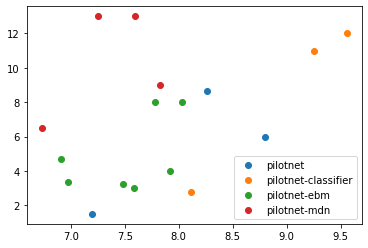

In [301]:
plot_df = same_dataset_df.groupby(['model_type', 'model_name']).mean()


# iterate over multiindex
for (model_type), group in plot_df.groupby(level=[0]):
    plt.scatter(group['elva_mae'], group['real_interventions'], label=model_type)

plt.legend()

In [317]:
def compute_correlations_interseed(df, candidate_cols = ['val_mae', 'elva_mae', 'elva_whiteness', 'vista_interventions'], target_col='real_interventions', verbose=False, plot=False):

    filtered_models = df.loc[df['model_name'].str.contains('ebm-512-s') | df['model_name'].str.contains('mae-s')]
    if verbose:
        display('only models with 3 seeds evaluated', filtered_models)


    by_type_and_name = filtered_models.groupby(['model_type', 'model_name'])
    if verbose:
        display('grouping by model type:', by_type_and_name.mean())

    corr_by_type = by_type_and_name.mean().groupby('model_type').corr('pearson').loc[idx[:, candidate_cols], [target_col]]
    corr_by_type_p_vals = by_type_and_name.mean().groupby('model_type').corr(pearsonr_pval).loc[idx[:, candidate_cols], [target_col]]
    corr_by_type.loc[:, 'p values'] = corr_by_type_p_vals[target_col]
    if verbose:
        display('corr by type:', corr_by_type)

    total = corr_by_type.groupby(level=1).mean().loc[candidate_cols]
    display('corr total:', total)
    if plot:
        plot_df = filtered_models.groupby(['model_type', 'model_name']).mean()
        for (model_type), group in plot_df.groupby(level=[0]):
            plt.scatter(group['elva_mae'], group['real_interventions'], label=model_type)
        plt.title(f"Pearson R: {total.loc['elva_mae', 'real_interventions']:.2f}, p-value: {total.loc['elva_mae', 'p values']:.2f}")
        plt.xlabel('Elva MAE')
        plt.ylabel('Interventions')
        plt.legend()
        plt.show()

def compute_correlations_interarchitecture(df, candidate_cols = ['val_mae', 'elva_mae', 'elva_whiteness', 'vista_interventions'], target_col='real_interventions', verbose=False, plot=False):

    # filtered_models = df.loc[df['model_name'].str.contains('ebm-512-s') | df['model_name'].str.contains('mae-s')]
    # if verbose:
    #     display('only manually specified models (with 3 seeds evaluated)', filtered_models)

    by_name = df.groupby(['model_name'])
    if verbose:
        display('grouping by model name:', by_name.mean())

    corr = by_name.mean().corr('pearson').loc[candidate_cols, [target_col]]
    corr_p_vals = by_name.mean().corr(pearsonr_pval).loc[candidate_cols, [target_col]]
    corr.loc[:, 'p values'] = corr_p_vals[target_col]
    
    display('corr:', corr)
    if plot:
        plot_df = df.groupby(['model_type', 'model_name']).mean()
        for (model_type), group in plot_df.groupby(level=[0]):
            plt.scatter(group['elva_mae'], group['real_interventions'], label=model_type)
        plt.title(f"Pearson R: {corr.loc['elva_mae', 'real_interventions']:.2f}, p-value: {corr.loc['elva_mae', 'p values']:.2f}")
        plt.xlabel('Elva MAE')
        plt.ylabel('Interventions')
        plt.legend()
        plt.show()

    # total = corr_by_type.groupby(level=1).mean().loc[candidate_cols]
    # if verbose:
    #     display('corr total:', total)
    # else:
    #     return total

#### On-policy

/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


'corr total:'

,real_interventions,p values
val_mae,0.684815,0.513621
elva_mae,0.822750,0.378339
elva_whiteness,0.442605,0.703193
vista_interventions,0.686456,0.512771
whiteness,-0.051020,0.278750
cmd_whiteness,0.560926,0.606725


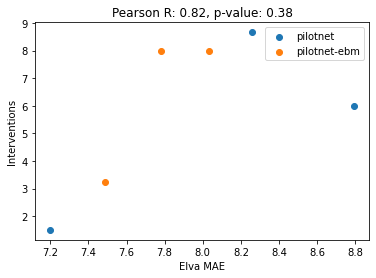

/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


'corr:'

,real_interventions,p values
val_mae,0.508128,0.063574
elva_mae,0.784609,0.000890
elva_whiteness,0.463008,0.095465
vista_interventions,0.542181,0.084885
whiteness,0.593685,0.025199
cmd_whiteness,0.554426,0.039637


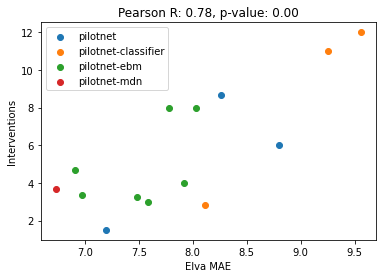

In [321]:
cand_cols = ['val_mae', 'elva_mae', 'elva_whiteness', 'vista_interventions', 'whiteness', 'cmd_whiteness']

compute_correlations_interseed(same_dataset_df, candidate_cols=cand_cols, verbose=False, plot=True)
# compute_correlations_interarchitecture(same_dataset_df, verbose=False, plot=True)
compute_correlations_interarchitecture(same_dataset_without_sunny_mdns_df, candidate_cols=cand_cols, verbose=False, plot=True)

In [254]:
# for ranking architectures

candidate_cols.remove('vista_interventions')

print('by model name:')
by_type_and_name = final_experiments.groupby(['model_name'])
display(by_type_and_name.mean())

print('corr:')
corr_by_type = by_type_and_name.mean().corr('pearson')
display(corr_by_type.loc[candidate_cols, ['real_interventions']])

# print('corr total:')
# total = corr_by_type.groupby(level=1).mean().loc[candidate_cols, ['real_interventions']]
# display(total)

by model name:


,real_interventions,elva_mae,elva_whiteness,elva_expert_whiteness,val_mae,traj_mae,traj_rmse,traj_max,traj_failure_rate,distance,distance_per_intervention,whiteness,cmd_whiteness,expert_whiteness
model_name,,,,,,,,,,,,,,
classifier-512,3.000000,8.117841,208.457916,17.679368,9.925803,0.430762,0.538518,1.681085,6.740301,8506.755036,6091.462743,45.773931,210.602684,17.655094
ebm-512-s1,2.333333,7.487386,191.060638,17.679368,8.607146,0.486291,0.600107,1.680288,9.785149,8484.136540,4944.386346,41.995219,229.219155,17.655094
ebm-normal-1-s1,3.333333,6.974703,152.191879,17.679368,8.437540,0.422710,0.530159,1.675475,6.451138,8489.256598,2923.931053,41.028450,111.295571,17.655094
ebm-spatial-0-s2,4.666667,6.909929,125.816818,17.679368,8.738031,0.447793,0.563639,1.613040,8.120504,8450.923249,1831.289728,36.116576,56.779543,17.655094
mae-s2,1.666667,7.196932,54.846653,17.679368,7.828012,0.428689,0.531593,1.619112,5.803563,8547.130941,5701.292993,27.537596,48.761025,17.655094
mdn-5-s1,3.666667,6.734990,74.416840,17.679368,9.070600,0.433356,0.542339,1.693785,6.551073,8456.163521,3962.666257,25.599471,35.490186,17.655094


corr:


,real_interventions
val_mae,0.382524
elva_mae,-0.409923
elva_whiteness,0.061615


In [191]:
np.array([0.8888, 0.6187, 0.3, 1]).mean()

0.701875

In [102]:
name_grouping

,real_interventions,elva_mae,elva_whiteness,elva_expert_whiteness,val_mae,vista_interventions,traj_mae,traj_rmse,traj_max,traj_failure_rate,distance,distance_per_intervention,whiteness,cmd_whiteness,expert_whiteness
model_name,,,,,,,,,,,,,,,
classifier-128,12.000000,9.554241,284.548401,17.679368,9.856725,22.000000,0.490083,0.591757,1.718230,8.440583,8313.780763,692.815064,46.809139,227.618274,17.655094
classifier-256,11.000000,9.254922,328.103699,17.679368,10.058057,32.000000,0.503680,0.618135,1.718893,10.127219,8322.859657,756.623605,44.207556,245.905479,17.655094
classifier-512,2.800000,8.117841,208.457916,17.679368,9.925803,15.000000,0.440209,0.550772,1.694254,7.467284,8521.844979,5797.628596,41.488817,180.044212,17.655094
ebm-128,3.000000,7.583857,232.103195,17.679368,8.340007,13.000000,0.491435,0.596341,1.721961,8.194858,8524.526158,2841.508719,34.146901,118.888527,17.655094
ebm-256,4.000000,7.919712,235.251266,17.679368,8.746287,10.000000,0.477159,0.581416,1.717646,8.151957,8476.586444,2119.146611,28.690812,112.794729,17.655094
ebm-512-s1,3.222222,7.487386,191.060638,17.679368,8.607146,1.000000,0.485386,0.598357,1.687180,9.509851,8489.764162,3470.808890,43.617838,212.926115,17.655094
ebm-512-s2,8.000000,8.032544,236.132935,17.679368,9.021556,44.000000,0.512559,0.631810,1.716886,11.942881,8447.418072,1055.927259,38.451471,236.495527,17.655094
ebm-512-s3,8.000000,7.782474,176.753128,17.679368,8.763485,6.000000,0.478503,0.583548,1.719953,8.526095,8393.941777,1049.242722,40.098021,208.159030,17.655094
ebm-normal-1-s1,3.333333,6.974703,152.191879,17.679368,8.437540,NaN,0.422710,0.530159,1.675475,6.451138,8489.256598,2923.931053,41.028450,111.295571,17.655094


In [100]:
target_cols = ['real_interventions']
candidate_cols = ['traj_mae', 'whiteness', 'cmd_whiteness']

finished_sessions_df = full_df.dropna(subset=['real_interventions'])

print('Finished sessions:', len(finished_sessions_df))
finished_sessions_df = finished_sessions_df[~finished_sessions_df['model_name'].str.contains('percent')]
name_grouping = finished_sessions_df.groupby('model_name').mean()

# correlation of traj mae is high only due to undertrained models being really bad and going all over the place. no correlation with decent models.
print('pearson')
pearson_corr = name_grouping.corr('pearson').loc[candidate_cols, target_cols]
pearson_pvals = name_grouping.corr(pearsonr_pval).loc[candidate_cols, target_cols]
pearson_corr.loc[:, 'p values'] = pearson_pvals[target_cols]
display(pearson_corr)

print('spearman')
spearman_corr = name_grouping.corr('spearman').loc[candidate_cols, target_cols]
spearman_pvals = name_grouping.corr(spearmanr_pval).loc[candidate_cols, target_cols]
spearman_corr.loc[:, 'p values'] = spearman_pvals[target_cols]
display(spearman_corr)

Finished sessions: 46
pearson


/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,real_interventions,p values
traj_mae,0.348163,0.170851
whiteness,0.584550,0.013725
cmd_whiteness,0.280052,0.276285


spearman


/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,real_interventions,p values
traj_mae,0.230675,0.373062
whiteness,0.541105,0.024894
cmd_whiteness,0.214724,0.407889


#### Off-policy

In [101]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)


target_cols = ['real_interventions']
candidate_cols = ['val_mae', 'elva_mae', 'elva_whiteness', 'vista_interventions']

print('pearson')
pearson_corr = name_grouping.corr('pearson').loc[candidate_cols, target_cols]
pearson_pvals = name_grouping.corr(pearsonr_pval).loc[candidate_cols, target_cols]
pearson_corr.loc[:, 'p values'] = pearson_pvals[target_cols]
display(pearson_corr)

print('spearman')
spearman_corr = name_grouping.corr('spearman').loc[candidate_cols, target_cols]
spearman_pvals = name_grouping.corr(spearmanr_pval).loc[candidate_cols, target_cols]
spearman_corr.loc[:, 'p values'] = spearman_pvals[target_cols]
display(spearman_corr)


pearson


/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,real_interventions,p values
val_mae,0.454966,0.066509
elva_mae,0.414779,0.097828
elva_whiteness,0.011918,0.963791
vista_interventions,0.349372,0.201810


spearman


/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,real_interventions,p values
val_mae,0.466258,0.059224
elva_mae,0.333743,0.190480
elva_whiteness,-0.024540,0.925517
vista_interventions,0.349287,0.201927


In [34]:
# dataframe: pearson_corr
# 1. Rename columns for the paper
# 2. Rename index for the paper
# 3. Export to Latex:
#   - Round values to 2 decimal places
#   - No index

pearson_corr_latex = pearson_corr.rename(columns={'real_interventions': 'Pearson R', 'p values': 'p'})
pearson_corr_latex = pearson_corr_latex.rename(index={'val_mae': 'MAE_{Validation set}', 'elva_mae': 'MAE_{Evaluation track}', 'elva_whiteness': 'Whiteness_{Evaluation track}', 'vista_interventions': 'Vista Interventions'})

formatters = {
    'Pearson R': lambda x: f'{x:.3f}',
    'p': lambda x: f'{x:.4f}',
}
print(pearson_corr_latex.to_latex(index=False, formatters=formatters))

\begin{tabular}{rr}
\toprule
Pearson R &      p \\
\midrule
    0.756 & 0.0002 \\
    0.762 & 0.0002 \\
    0.683 & 0.0013 \\
    0.025 & 0.9188 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_27771/1975970085.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pearson_corr_latex.to_latex(index=False, formatters=formatters))


##### Only cloudy weather

In [198]:
cloudy_df = df[df.apply(lambda x: x['drive'][0].startswith('e2e'), axis=1)]
cloudy_df

,training_run,model_name,real_interventions,drive,elva_mae,elva_whiteness,elva_expert_whiteness,val_mae,model_type,vista_interventions,traj_mae,traj_rmse,traj_max,traj_failure_rate,distance,distance_per_intervention,whiteness,cmd_whiteness,expert_whiteness
24,3ftnqxcb,ebm-512-s1,2,"(e2e-ebm-512-s1-forward_2022-09-13-10-33-34, e...",7.4874,191.0606,17.6794,8.6071,pilotnet-ebm,1.0000,0.4470,0.5574,1.6531,7.8945,8413.3545,4206.6773,32.9799,153.3793,17.6551
25,2yofzwf0,ebm-50percent-s2,23,(e2e-ebm-50percent-s2-forward_2022-09-13-11-19...,9.6279,303.5878,17.6794,9.1987,pilotnet-ebm,12.0000,0.4903,0.6101,1.7171,11.5622,8174.6189,355.4182,55.0562,266.9290,17.6551
26,zie8x2vl,ebm-20percent-s2,23,(e2e-ebm-20percent-s2-forward_2022-09-13-12-10...,10.8179,426.1624,17.6794,11.6304,pilotnet-ebm,5.0000,0.5819,0.7095,1.7223,18.0337,8061.9341,350.5189,53.1540,171.4198,17.6551
27,3g3wwx73,classifier-512,4,(e2e-classifier-512-forward_2022-09-13-10-56-5...,8.1178,208.4579,17.6794,9.9258,pilotnet-classifier,15.0000,0.4510,0.5683,1.7083,9.1664,8500.2734,2125.0683,36.3163,192.9108,17.6551
28,1t56cx3v,classifier-50percent-s1,16,(e2e-classifier-50percent-s1-forward_2022-09-1...,11.7338,717.4335,17.6794,12.8551,pilotnet-classifier,29.5000,0.5000,0.6110,1.7159,9.8832,8352.2074,522.0130,53.2675,427.5926,17.6551
29,2ldsn0i0,classifier-20percent-s2,31,(e2e-classifier-20percent-s2-forward_2022-09-1...,16.6350,1068.3125,17.6794,15.8028,pilotnet-classifier,18.0000,0.5716,0.7018,1.7224,16.9970,8007.1150,258.2940,75.4119,433.9626,17.6551


In [199]:
target_cols = ['real_interventions']
candidate_cols = ['val_mae', 'elva_mae', 'elva_whiteness', 'vista_interventions']
name_grouping = cloudy_df.dropna().groupby('model_name').mean()

print('pearson')
pearson_corr = name_grouping.corr('pearson').loc[candidate_cols, target_cols]
pearson_pvals = name_grouping.corr(pearsonr_pval).loc[candidate_cols, target_cols]
pearson_corr.loc[:, 'p values'] = pearson_pvals[target_cols]
display(pearson_corr)

print('spearman')
spearman_corr = name_grouping.corr('spearman').loc[candidate_cols, target_cols]
spearman_pvals = name_grouping.corr(spearmanr_pval).loc[candidate_cols, target_cols]
spearman_corr.loc[:, 'p values'] = spearman_pvals[target_cols]
display(spearman_corr)


pearson


/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,real_interventions,p values
val_mae,0.7044,0.1182
elva_mae,0.8337,0.0392
elva_whiteness,0.7317,0.0983
vista_interventions,0.2666,0.6095


spearman


/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,real_interventions,p values
val_mae,0.6667,0.1481
elva_mae,0.8117,0.0499
elva_whiteness,0.8117,0.0499
vista_interventions,0.3479,0.4993


#### Vista vs Trajectory Failure?

In [181]:
target_cols = ['vista_interventions']
candidate_cols = ['traj_mae', 'traj_failure_rate']

name_grouping = df.dropna().groupby('model_name').mean()

print('pearson')
pearson_corr = name_grouping.corr('pearson').loc[candidate_cols, target_cols]
pearson_pvals = name_grouping.corr(pearsonr_pval).loc[candidate_cols, target_cols]
pearson_corr.loc[:, 'p values'] = pearson_pvals[target_cols]
display(pearson_corr)

print('spearman')
spearman_corr = name_grouping.corr('spearman').loc[candidate_cols, target_cols]
spearman_pvals = name_grouping.corr(spearmanr_pval).loc[candidate_cols, target_cols]
spearman_corr.loc[:, 'p values'] = spearman_pvals[target_cols]
display(spearman_corr)


pearson


/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,vista_interventions,p values
traj_mae,0.090,0.715
traj_failure_rate,0.005,0.984


spearman


/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,vista_interventions,p values
traj_mae,0.192,0.430
traj_failure_rate,0.115,0.640


In [155]:
df.dropna().groupby(['model_type', 'model_name']).mean()

real_interventions   elva_mae  \
model_type          model_name                                               
pilotnet            mae-s1                                11.25   8.258923   
                    mae-s2                                  1.0   7.196932   
                    mae-s3                                  6.0   8.794627   
pilotnet-classifier classifier-128                         12.0   9.554241   
                    classifier-20percent-s2                31.0  16.635045   
                    classifier-256                         11.0   9.254922   
                    classifier-50percent-s1                16.0  11.733754   
                    classifier-512                          2.5   8.117841   
pilotnet-ebm        ebm-128                                 3.0   7.583857   
                    ebm-20percent-s2                       23.0  10.817906   
                    ebm-256                                 4.0   7.919712   
                    ebm-50percent-s2                       23.0   9.627881   
                    ebm-512-s1                         3.666667   7.487386   
                    ebm-512-s2                              8.0   8.032544   
                    ebm-512-s3                              8.0   7.782474   
pilotnet-mdn        mdn-3-s2                                9.0   7.826568   
                    mdn-3-s3                               13.0   7.247706   
                    mdn-5-s1                               15.0   6.734990   
                    mdn-5-s2                               13.0   7.591263   

                                             elva_whiteness  \
model_type          model_name                                
pilotnet            mae-s1                        64.583984   
                    mae-s2                        54.846653   
                    mae-s3                        75.330704   
pilotnet-classifier classifier-128               284.548401   
                    classifier-20percent-s2     1068.312500   
                    classifier-256               328.103699   
                    classifier-50percent-s1      717.433472   
                    classifier-512               208.457916   
pilotnet-ebm        ebm-128                      232.103195   
                    ebm-20percent-s2             426.162384   
                    ebm-256                      235.251266   
                    ebm-50percent-s2             303.587830   
                    ebm-512-s1                   191.060638   
                    ebm-512-s2                   236.132935   
                    ebm-512-s3                   176.753128   
pilotnet-mdn        mdn-3-s2                      78.490372   
                    mdn-3-s3                      67.758331   
                    mdn-5-s1                      74.416840   
                    mdn-5-s2                     129.646042   

                                             elva_expert_whiteness    val_mae  \
model_type          model_name                                                  
pilotnet            mae-s1                               17.679368   8.128144   
                    mae-s2                               17.679368   7.828012   
                    mae-s3                               17.679368   8.483535   
pilotnet-classifier classifier-128                       17.679368   9.856725   
                    classifier-20percent-s2              17.679368  15.802833   
                    classifier-256                       17.679368  10.058057   
                    classifier-50percent-s1              17.679368  12.855070   
                    classifier-512                       17.679368   9.925803   
pilotnet-ebm        ebm-128                              17.679368   8.340007   
                    ebm-20percent-s2                     17.679368  11.630416   
                    ebm-256                              17.679368   8.746287   
                    ebm-50per

In [202]:
idx = pd.IndexSlice

# disable scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

target_cols = ['real_interventions']
candidate_cols = ['val_mae', 'elva_mae', 'vista_interventions']

type_name_grouping = df.dropna().groupby(['model_type', 'model_name']).mean().groupby('model_type')

print('Correlation with Interventions:')
pearson_corr = type_name_grouping.corr('pearson').loc[idx[:, candidate_cols], target_cols]
spearman_corr = type_name_grouping.corr('spearman').loc[idx[:, candidate_cols], target_cols]
pearson_pvals = type_name_grouping.corr(pearsonr_pval).loc[idx[:, candidate_cols], target_cols]
spearman_pvals = type_name_grouping.corr(spearmanr_pval).loc[idx[:, candidate_cols], target_cols]

pearson_corr['Pearson'] = pearson_corr['real_interventions']
pearson_corr.loc[:, 'p values (Pearson)'] = pearson_pvals['real_interventions']
pearson_corr['Spearman'] = spearman_corr['real_interventions']
pearson_corr.loc[:, 'p values (Spearman)'] = spearman_pvals['real_interventions']

corr = pearson_corr
del corr['real_interventions']
display(corr)

Correlation with Interventions:


/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,,Pearson,p values (Pearson),Spearman,p values (Spearman)
model_type,,,,,
pilotnet,val_mae,0.445,0.707,0.500,0.667
pilotnet-classifier,val_mae,0.924,0.025,0.700,0.188
pilotnet-ebm,val_mae,0.767,0.044,0.982,0.000
pilotnet-mdn,val_mae,0.318,0.682,0.632,0.368
pilotnet,elva_mae,0.642,0.556,0.500,0.667
pilotnet-classifier,elva_mae,0.979,0.004,1.000,0.000
pilotnet-ebm,elva_mae,0.948,0.001,0.891,0.007
pilotnet-mdn,elva_mae,-0.876,0.124,-0.949,0.051
pilotnet,vista_interventions,0.873,0.324,0.866,0.333


In [120]:
idx = pd.IndexSlice
df.dropna().groupby('model_type').corr(pearsonr_pval).loc[idx[:, ('val_mae', 'vista_interventions')], ['real_interventions']]

/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/nikita/miniconda3/envs/e2e/lib/python3.9/site-packages/pandas/core/common.py:241: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


TypeError: unhashable type: 'slice'

In [99]:
calculate_pvalues(df.dropna(), 'spearman').loc[:, ['real_interventions']]

,real_interventions
real_interventions,0.0
val_mae,0.3482
vista_interventions,0.0395


In [19]:
df.dropna()._get_numeric_data().corr(method='spearman').loc[['real_interventions']]

,MAE,vista_interventions,real_interventions
real_interventions,0.895604,0.54756,1.0


In [20]:
df.dropna()._get_numeric_data().corr(method='pearson').loc[['real_interventions']]

,MAE,vista_interventions,real_interventions
real_interventions,0.973962,0.990665,1.0


In [25]:
calculate_pvalues(df, 'spearman').loc[['real_interventions']]

,MAE,vista_interventions,real_interventions
real_interventions,0.0064,0.2033,0.0


In [24]:
calculate_pvalues(df, 'pearson').loc[['real_interventions']]

,MAE,vista_interventions,real_interventions
real_interventions,0.0002,0.0,0.0


In [17]:
df.dropna()._get_numeric_data()

,MAE,vista_interventions,real_interventions
0,9.071,8,15.0
1,8.941,6,13.0
2,8.941,8,13.0
5,8.927,11,9.0
6,9.513,12,13.0
7,10.813,55,100.0
8,10.813,62,100.0


### Intersection handling

In [ ]:
dff = datasets_forward['2022-09-08-10-13-30_ebm-512-s1 (forward)'].frames
dfb = datasets_backward['2022-09-08-10-13-30_ebm-512-s1 (backward)'].frames
intersection_start_forward = dff[dff['position_x'] < -8040].iloc[0]
intersection_start_forward_loc = intersection_start_forward[['position_x', 'position_y']].to_numpy().astype(np.float32)
intersection_start_backward = dfb[dfb['position_x'] > -8085].iloc[0]
intersection_start_backward_loc = intersection_start_backward[['position_x', 'position_y']].to_numpy().astype(np.float32)

Image(intersection_start_forward.image_path)

In [ ]:
Image(intersection_start_backward.image_path)

In [ ]:
ds

In [ ]:
get_closest_frame_by_loc(ds)

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(15, 30))

for i, (name, ds) in enumerate(datasets_forward.items()): 
    if i > 3: break

    print(i, name)
    closest ds.frames

### Plots

In [26]:
def draw_error_plot_ax(ax, model_ds, expert_ds, title=None):
    lat_errors = calculate_lateral_errors(model_ds.frames[:-1000], expert_ds.frames, only_autonomous=True)
    positions_df = model_ds.frames[:-1000]
    
    autonomous_df = positions_df[positions_df.autonomous].reset_index(drop=True)
    ax.scatter(autonomous_df["position_x"], autonomous_df["position_y"],
               s=5,
               c=lat_errors, cmap=plt.cm.coolwarm)
    
    manual_df = positions_df[positions_df.autonomous == False].reset_index(drop=True)
    ax.scatter(manual_df["position_x"], manual_df["position_y"],
                s=5,
                c="#2BFA00")
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        positions_df['autonomous_next'] = positions_df.shift(-1)['autonomous']
    interventions_df = positions_df[positions_df.autonomous & (positions_df.autonomous_next == False)]
    ax.scatter(interventions_df["position_x"], interventions_df["position_y"],
                s=150,
               marker='x',
                c="red")
    
    if title:
        ax.set_title(title)

In [20]:
datasets_forward = {}
datasets_backward = {}

for i, row in tqdm(df.iterrows()):
    drives = row['drive']
    ds_forward = None
    ds_backward = None
    forward_metrics = {}
    backward_metrics = {}
    title_forward = None
    title_backward = None

    if len(drives) == 1:
        ds_combined = NvidiaDataset([root_path / drives[0]])
        if drives[0] not in ['2022-09-09-11-47-04', '2022-09-09-10-51-33-mdn-1-s1']: # interrupted single direction drives
            ds_forward, ds_backward = split_back_forth_drive_into_two(ds_combined)
            title_forward = drives[0] + ' (forward)'
            title_backward = drives[0] + ' (backward)'
        else:
            ds_forward = ds_combined
            title_forward = drives[0]
    elif len(drives) == 2:
        ds_forward = NvidiaDataset([root_path / drives[0]])
        ds_backward = NvidiaDataset([root_path / drives[1]])
        title_forward = drives[0]
        title_backward = drives[1]
    elif len(drives) == 3:
        assert '2022-08-31-15-18-55_elva_classifier_512_forward_continued' in drives[1]
        ds_forward = NvidiaDataset([root_path / drives[0], root_path / drives[1]])
        ds_backward = NvidiaDataset([root_path / drives[2]])
        title_forward = drives[0] + ' + continued'
        title_backward = drives[2]

    if ds_forward is not None and title_forward is not None:
        datasets_forward[title_forward] = ds_forward
    if ds_backward is not None and title_backward is not None:
        datasets_backward[title_backward] = ds_backward

2it [00:00, 13.43it/s]

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-11-47-04: length=3364, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-10-51-33-mdn-1-s1: length=4700, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-10-04-05-mdn-3-s2: length=38861, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


4it [00:01,  3.12it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-11-23-11-mdn-3-s3: length=38857, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


5it [00:01,  2.81it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-11-00-03-mdn-5-s1: length=38100, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


6it [00:02,  2.64it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-10-27-50-mdn-5-s2: length=38317, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-37-37_elva_ebm_512_front: length=17873, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


7it [00:02,  2.44it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-48-15_elva_ebm_512_back: length=18822, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-29-08_elva_ebm_256_front: length=17991, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


8it [00:03,  2.25it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-42-01_elva_ebm_256_back: length=18865, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


9it [00:03,  2.33it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-17-16-19_elva_ebm_128_front: length=17972, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-17-26-53_elva_ebm_128_back: length=18390, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-14-52-25_elva_classifier_512_forward: length=5921, filtered=0
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-18-55_elva_classifier_512_forward_continued: length=11356, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


10it [00:03,  2.37it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-26-05_elva_classifier_512_back: length=18521, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-00-20_elva_classifier_256_front: length=18051, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


11it [00:04,  2.17it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-11-28_elva_classifier_256_back: length=18668, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-53-38_elva_classifier_128_front: length=18373, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


12it [00:04,  2.03it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-17-04-28_elva_classifier_128_back: length=18543, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


13it [00:05,  2.03it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-11-04-39_elva_ebm_512_s1_rep1: length=38117, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


14it [00:05,  2.14it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-11-27-02_elva_ebm_512_s1_rep2: length=37417, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


15it [00:06,  2.18it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-11-48-55_elva_ebm_512_s1_rep3: length=37321, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


16it [00:06,  2.27it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-10-13-30_ebm-512-s1: length=37129, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


17it [00:07,  2.31it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-10-38-33_ebm_512_s2: length=37368, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


18it [00:07,  2.37it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-11-01-21_ebm-512-s3: length=37803, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


19it [00:07,  2.37it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-09-54-31_elva_mae_s1_rep1: length=37619, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


20it [00:08,  2.39it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-10-20-29_elva_mae_s1_rep2: length=37279, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


21it [00:08,  2.39it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-10-42-07_elva_mae_s1_rep3: length=38435, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


22it [00:09,  2.44it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-11-26-29_mae-s1: length=37241, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


23it [00:09,  2.38it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-11-49-08_mae-s2: length=37280, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


24it [00:10,  2.36it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-12-13-25_mae-s3: length=38024, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-512-s1-forward_2022-09-13-10-33-34: length=18211, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


25it [00:10,  2.17it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-512-s1-backward_2022-09-13-10-44-25: length=18448, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-50percent-s2-forward_2022-09-13-11-19-28: length=18740, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


26it [00:11,  2.05it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-50percent-s2-backward_2022-09-13-11-30-33: length=18767, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-20percent-s2-forward_2022-09-13-12-10-23: length=18348, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


27it [00:11,  1.98it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-20percent-s2-backward_2022-09-13-12-21-25: length=18946, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-512-forward_2022-09-13-10-56-50: length=17994, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


28it [00:12,  1.95it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-512-backward_2022-09-13-11-07-29: length=18350, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-50percent-s1-forward_2022-09-13-11-42-53: length=18860, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


29it [00:12,  1.89it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-50percent-s1-backward_2022-09-13-11-53-59: length=18902, filtered=0
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-20percent-s2-forward_2022-09-13-12-33-22: length=19363, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


30it [00:13,  2.25it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-20percent-s2-backward_2022-09-13-12-44-44: length=18792, filtered=0


In [19]:
datasets_backward

{None: None,
 '2022-09-09-10-04-05-mdn-3-s2 (backward)': <dataloading.nvidia.NvidiaDataset at 0x7f7b9ce8d040>,
 '2022-09-09-11-23-11-mdn-3-s3 (backward)': <dataloading.nvidia.NvidiaDataset at 0x7f7b9ce8d3d0>,
 '2022-09-09-11-00-03-mdn-5-s1 (backward)': <dataloading.nvidia.NvidiaDataset at 0x7f7b9fbc22b0>,
 '2022-09-09-10-27-50-mdn-5-s2 (backward)': <dataloading.nvidia.NvidiaDataset at 0x7f7b9f9ba040>,
 '2022-08-31-15-48-15_elva_ebm_512_back': <dataloading.nvidia.NvidiaDataset at 0x7f7b9fa15be0>,
 '2022-08-31-16-42-01_elva_ebm_256_back': <dataloading.nvidia.NvidiaDataset at 0x7f7b9fbc2dc0>,
 '2022-08-31-17-26-53_elva_ebm_128_back': <dataloading.nvidia.NvidiaDataset at 0x7f7ba0685f70>,
 '2022-08-31-15-26-05_elva_classifier_512_back': <dataloading.nvidia.NvidiaDataset at 0x7f7b9f93f310>,
 '2022-08-31-16-11-28_elva_classifier_256_back': <dataloading.nvidia.NvidiaDataset at 0x7f7b9eafe850>,
 '2022-08-31-17-04-28_elva_classifier_128_back': <dataloading.nvidia.NvidiaDataset at 0x7f7b9ce93d90>

In [28]:
del datasets_forward['2022-09-09-11-47-04']
del datasets_forward['2022-09-09-10-51-33-mdn-1-s1']

0 2022-09-09-10-04-05-mdn-3-s2 (forward)
1 2022-09-09-11-23-11-mdn-3-s3 (forward)
2 2022-09-09-11-00-03-mdn-5-s1 (forward)
3 2022-09-09-10-27-50-mdn-5-s2 (forward)


IndexError: index 3 is out of bounds for axis 0 with size 3

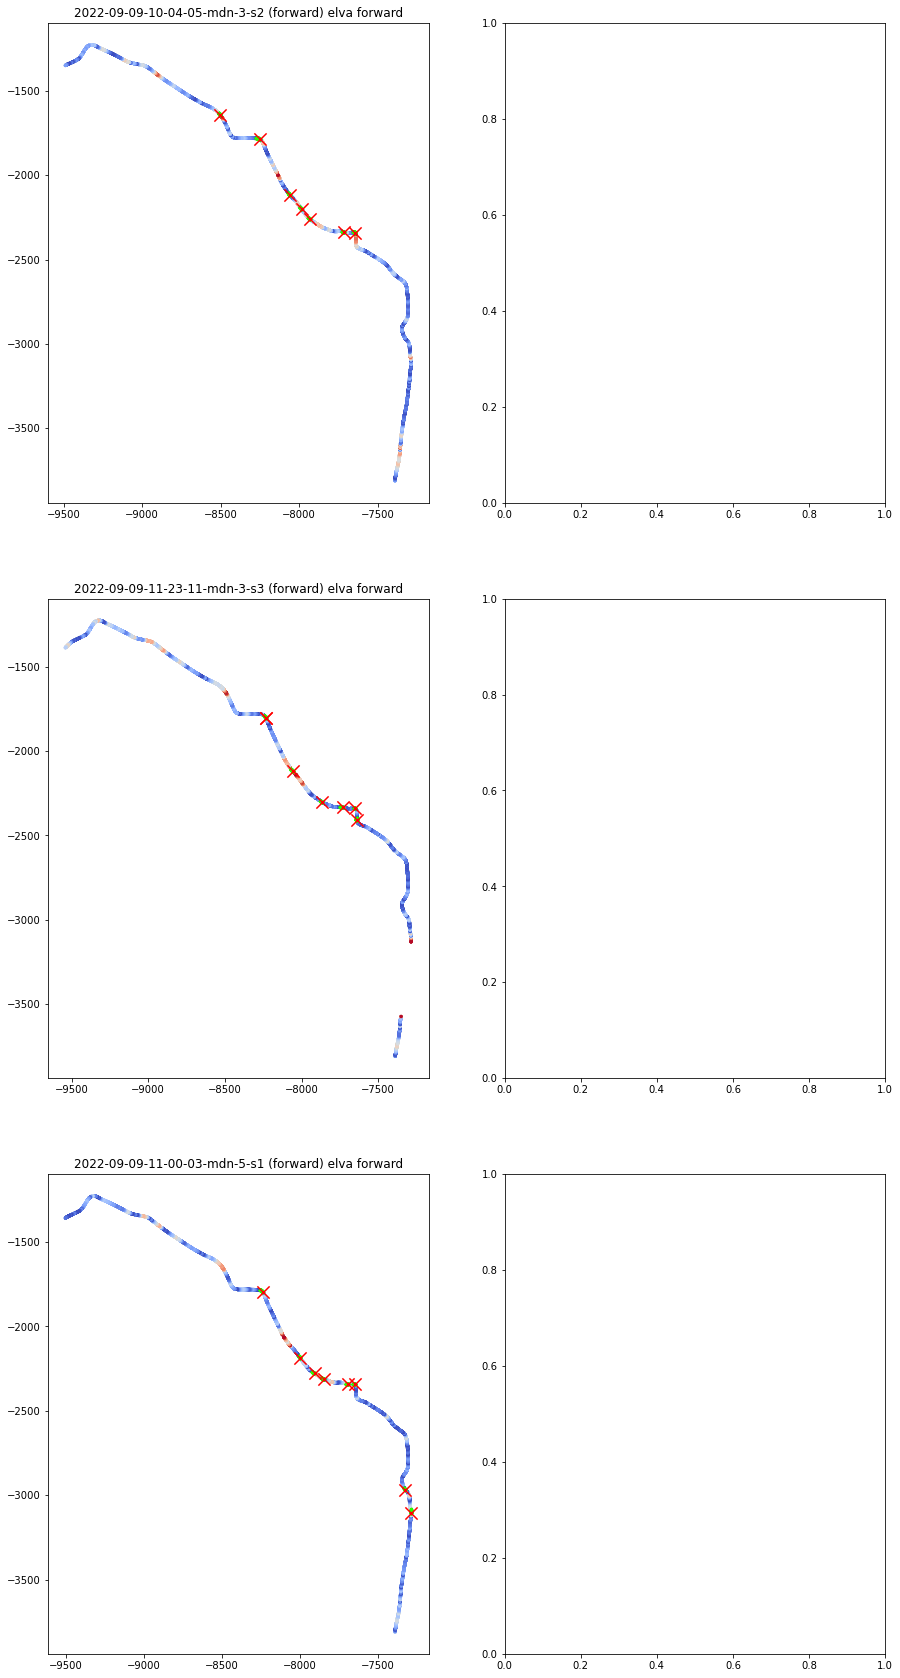

In [29]:
import matplotlib.pyplot as plt
from metrics.metrics import calculate_lateral_errors

fig, ax = plt.subplots(3, 2, figsize=(15, 30))

for i, (name, ds) in enumerate(datasets_forward.items()): 
    if i >= 3:
        break
    print(i, name)
    draw_error_plot_ax(ax[i][0], ds, expert_ds, f"{name} elva forward")
    
    
for i, (name, ds) in enumerate(datasets_backward.items()): 
    if i >= 3:
        break
    print(i, name)
    draw_error_plot_ax(ax[i][1], ds, expert_back_ds, f"{name} Elva backward")
    

Things left to do:

schedule:
- track_mae
- ~~vista_interventions~~

Instant:
- whiteness (eff, pred)
- trajectory mae + failure rate
- (stretch) whiteness over time (on map), on-policy and human
- (stretch) trajectory mae over time (on map), on-policy